In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# import dataset
df = pd.read_csv("data/gold.csv")

In [65]:
df = df.drop(columns=['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               7043 non-null   object 
 1   SeniorCitizen        7043 non-null   object 
 2   Partner              7043 non-null   object 
 3   Dependents           7043 non-null   object 
 4   tenure               7043 non-null   int64  
 5   PhoneService         7043 non-null   object 
 6   MultipleLines        7043 non-null   object 
 7   InternetService      7043 non-null   object 
 8   Contract             7043 non-null   object 
 9   PaperlessBilling     7043 non-null   object 
 10  PaymentMethod        7043 non-null   object 
 11  MonthlyCharges       7043 non-null   float64
 12  TotalCharges         7043 non-null   float64
 13  Churn                7043 non-null   object 
 14  nb_service_internet  7043 non-null   int64  
dtypes: float64(2), int64(2), object(11)
me

In [66]:
from sklearn.model_selection import train_test_split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)

In [67]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()


y_train =  labelencoder.fit_transform(y_train)

y_test = labelencoder.transform(y_test)

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

categorial_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
       'PhoneService', 'MultipleLines', 'InternetService','Contract', 'PaperlessBilling', 'PaymentMethod'
       ]

numerical_features = list(X.select_dtypes(include=[int,float]).columns)

categorical_transformer = OneHotEncoder(sparse_output=True)

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorial_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

log_reg = LogisticRegression(penalty='l2', C=0.01)

pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('log_reg', log_reg)
])

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'nb_service_internet'])])),
                ('log_reg', LogisticRegression(C=0.01))])

In [69]:

import mlflow

experiment_id = mlflow.set_experiment("churn_model").experiment_id

run_name = "reglog_C_small_stdscaler"

with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
    # Log the baseline model to MLflow
    pipe.fit(X_train, y_train)
    
    
    mlflow.sklearn.log_model(pipe, run_name)

    
    model_uri = mlflow.get_artifact_uri(run_name)

    # Log des paramètres

    mlflow.log_param("C",0.8)

    # Log des Tags
    mlflow.set_tag("model","logistic_regression")
    mlflow.set_tag("regularisation",True)

    eval_data = X_test
    eval_data["label"] = y_test

    # Evaluate the logged model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )

2023/05/12 14:50:10 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/05/12 14:50:10 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2023/05/12 14:50:11 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


In [70]:
y_pred_test = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)


In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
print("######## accuracy_score : ")
print("TRAIN :",accuracy_score(y_train, y_pred_train))
print("TEST :",accuracy_score(y_test, y_pred_test))

print("######## precision_score : ")
print("TRAIN :",precision_score(y_train, y_pred_train))
print("TEST :",precision_score(y_test, y_pred_test))

print("######## recall_score : ")    
print("TRAIN :",recall_score(y_train, y_pred_train))
print("TEST :",recall_score(y_test, y_pred_test))

print("######## f1_score : ")
print("TRAIN :",f1_score(y_train, y_pred_train))
print("TEST :",f1_score(y_test, y_pred_test))

######## accuracy_score : 
TRAIN : 0.7983670571529996
TEST : 0.8140525195173882
######## precision_score : 
TRAIN : 0.6682242990654206
TEST : 0.6989247311827957
######## recall_score : 
TRAIN : 0.47794117647058826
TEST : 0.5227882037533512
######## f1_score : 
TRAIN : 0.5572876071706937
TEST : 0.5981595092024541


<Figure size 1050x700 with 0 Axes>

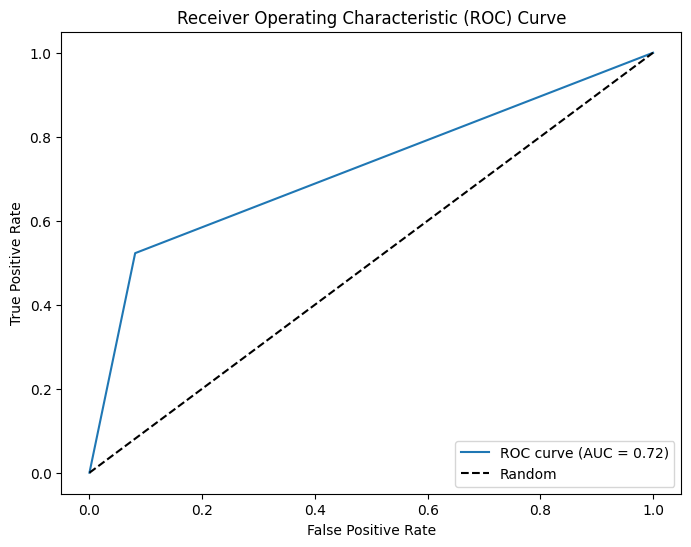

######## roc_auc_score : 
TRAIN : 0.6960754698206011
TEST : 0.7208535613361351


In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_test)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("######## roc_auc_score : ")    
print("TRAIN :",roc_auc_score(y_train, y_pred_train))
print("TEST :",roc_auc_score(y_test, y_pred_test))  



## Cross-validation

In [73]:
log_rev_cv = LogisticRegressionCV(cv=5)

pipe_cv = Pipeline([
     ('preprocessor', preprocessor),
     ('log_reg', log_rev_cv)
])

pipe_cv

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'nb_service_internet'])])),
                ('log_reg', LogisticRegressionCV(cv=5))])

In [74]:
experiment_id = mlflow.set_experiment("churn_model").experiment_id

run_name = "reglog_cv"

with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
    # Log the baseline model to MLflow
    pipe_cv.fit(X_train, y_train)
    
    
    mlflow.sklearn.log_model(pipe_cv, run_name)

    
    model_uri = mlflow.get_artifact_uri(run_name)

    # Log des paramètres

    mlflow.log_param("C",0.8)

    # Log des Tags
    mlflow.set_tag("model","logistic_regression")
    mlflow.set_tag("regularisation",True)

    eval_data = X_test
    eval_data["label"] = y_test

    # Evaluate the logged model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )

2023/05/12 14:50:18 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/05/12 14:50:18 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2023/05/12 14:50:19 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


In [75]:
pipe_cv.score(X_test, y_test)

0.8197303051809794

In [76]:
pipe_cv[1].scores_[1]

array([[0.73469388, 0.73913043, 0.78881988, 0.80479148, 0.80124224,
        0.8065661 , 0.80567879, 0.80567879, 0.80567879, 0.80567879],
       [0.73469388, 0.73824312, 0.81100266, 0.81100266, 0.81277728,
        0.8136646 , 0.80922804, 0.80834073, 0.80834073, 0.80834073],
       [0.73469388, 0.74001775, 0.7826087 , 0.78881988, 0.79680568,
        0.80212955, 0.80212955, 0.80212955, 0.80212955, 0.80212955],
       [0.73380657, 0.74267968, 0.78970719, 0.79680568, 0.79148181,
        0.79503106, 0.7905945 , 0.78970719, 0.78970719, 0.78970719],
       [0.73445826, 0.73889876, 0.79307282, 0.80284192, 0.80106572,
        0.80195382, 0.80106572, 0.80106572, 0.80106572, 0.80106572]])

In [77]:
pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                    ['gender', 'SeniorCitizen', 'Partner',
                                     'Dependents', 'PhoneService', 'MultipleLines',
                                     'InternetService', 'Contract',
                                     'PaperlessBilling', 'PaymentMethod']),
                                   ('num', StandardScaler(),
                                    ['tenure', 'MonthlyCharges', 'TotalCharges',
                                     'nb_service_internet'])])),
  ('log_reg', LogisticRegression(C=0.01))],
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                  ['gender', 'SeniorCitizen', 'Partner',
                                   'Dependents', 'PhoneService', 'MultipleLines',
                                   'InternetService', 'Contract',
                           

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# paras qu'on veut tester
# la syntax log_reg__x est lié au fait qu'on utilise un pipeline
# pour avoir la liste des params, on peut utiliser la méthode .get_params() ci_dessus
params = {
    'log_reg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'log_reg__C': np.arange(1,11),
    'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

## 200 combinaisons

# Créer un objet GridSearchCV avec votre pipeline, les paramètres que vous voulez tester, et la métrique de performance que vous voulez utiliser
grid_search = GridSearchCV(pipe, params, cv=5, scoring='f1', refit='f1')

grid_search.fit(X_train, y_train)
print(grid_search.cv_results_) # pr voir tous les resultats

print("Best parameters: ", grid_search.best_params_)

# Utiliser le meilleur modèle pour faire des prédictions sur les données de test
y_pred_test = grid_search.predict(X_test)
#va faire des predictions sur y_test
score_test = grid_search.score(X_test, y_test)
#évalue la performance du modéle en donnant le y test

#score = model.score(X_train, y_train, X_test, y_test)
# Afficher la métrique de performance ROC AUC pour le meilleur modèle sur les données de test
print("F1 score :", f1_score(y_test, y_pred_test))

/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.

{'mean_fit_time': array([0.01302824, 0.0097826 , 0.21764507, 0.01087255, 0.15226831,
       0.11961403, 0.09087114, 0.02857242, 0.16957374, 0.19292936,
       0.02276521, 0.01704464, 0.01240416, 0.00907044, 0.0116643 ,
       1.10078812, 0.06687136, 0.01321979, 0.08186169, 0.09689317,
       0.01291308, 0.02423458, 0.26975231, 0.0157392 , 0.15250077,
       1.20826054, 0.24617457, 0.02456799, 0.14558225, 0.16315856,
       0.01631513, 0.01389856, 0.01182837, 0.01184912, 0.00812125,
       0.43412642, 0.05427203, 0.01072388, 0.0765821 , 0.12847204,
       0.01342907, 0.01336379, 0.36137233, 0.0268662 , 0.15182047,
       0.79714184, 0.10643249, 0.02643895, 0.12537179, 0.15512242,
       0.01401663, 0.0161581 , 0.015135  , 0.0141067 , 0.00993152,
       0.09755368, 0.63137822, 0.01369696, 0.07471743, 0.14111314,
       0.02699652, 0.01510324, 0.55542412, 0.02182851, 0.18254256,
       0.18325777, 0.08149538, 0.0515214 , 0.16969242, 0.1717957 ,
       0.02631197, 0.01543651, 0.01134462, 0

In [88]:
np.arange(1e-4,1e3).shape

(1000,)

In [91]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_dist = {
    'log_reg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'log_reg__C': np.arange(1e-4,1e3),
    'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

#  objet RandomizedSearchCV, la distribution d'hyperparamètres que vous voulez tester, le nombre d'itérations que vous voulez faire et la métrique de performance que vous voulez utiliser
random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=100, cv=5, scoring='f1')

# Faire tourner le RandomizedSearchCV
random_search.fit(X_train, y_train)

# Récupérer les meilleurs paramètres trouvés 
best_params_random = random_search.best_params_
print(best_params_random) #on a un dictionnaire avec en clés les hyperparamètres sur lesquels on a demandé d'agir

print (random_search.best_params_
       )
# Définir une nouvelle grille de paramètres centrée sur les meilleurs paramètres trouvés par RandomizedSearchCV
params = {
    'log_reg__penalty': [best_params_random['log_reg__penalty']],
    'log_reg__C': [
        best_params_random['log_reg__C'] - best_params_random['log_reg__C']/10,
        best_params_random['log_reg__C'],
        best_params_random['log_reg__C'] + best_params_random['log_reg__C']/10],
    'log_reg__solver': [best_params_random['log_reg__solver']]
}


grid_search = GridSearchCV(pipe, params, cv=5, scoring='f1')

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)

# Utiliser le meilleur modèle pour faire des prédictions sur les données de test
y_pred_test = grid_search.predict(X_test)

print("f1 score:", roc_auc_score(y_test, y_pred_test))

/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.

{'log_reg__solver': 'saga', 'log_reg__penalty': 'l1', 'log_reg__C': 5.0001}
{'log_reg__solver': 'saga', 'log_reg__penalty': 'l1', 'log_reg__C': 5.0001}
Best parameters:  {'log_reg__C': 5.500109999999999, 'log_reg__penalty': 'l1', 'log_reg__solver': 'saga'}
ROC AUC score: 0.7477693127827175


## Courbes de validation

<Figure size 1050x700 with 0 Axes>

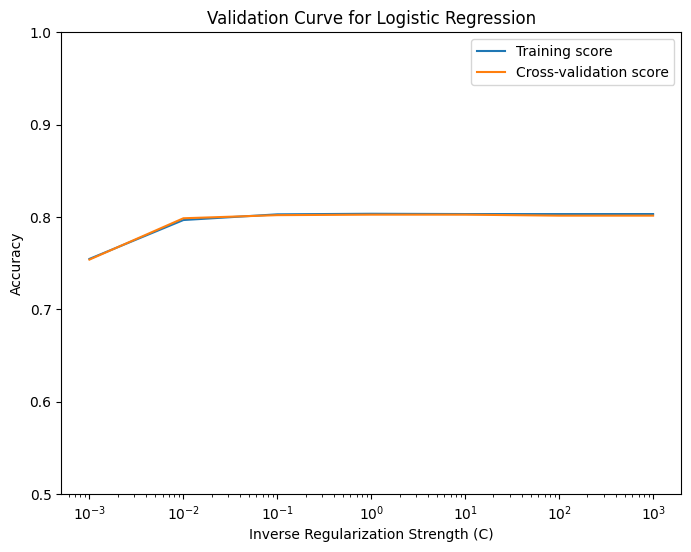

In [92]:

# Importer les librairies requises
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

# Définir une plage de valeurs pour l'hyperparamètre, ici C
param_range = np.logspace(-3, 3, 7)

# Calculer les scores de validation croisée pour chaque valeur de l'hyperparamètre
train_scores, valid_scores = validation_curve(
    pipe, X_train, y_train, 
    param_name='log_reg__C', 
    param_range=param_range,
    cv=5, scoring="accuracy"        #"f1", "recall", "roc_auc"
)

# Calculer la moyenne des scores d'entraînement et de validation pour chaque valeur de l'hyperparamètre
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

# Tracer la courbe de validation
plt.figure(figsize=(8, 6))
plt.title("Validation Curve for Logistic Regression")
plt.xlabel("Inverse Regularization Strength (C)")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)

plt.semilogx(param_range, train_mean, label="Training score")
plt.semilogx(param_range, valid_mean, label="Cross-validation score")

plt.legend(loc="best")
plt.show()

## SVM

In [93]:
from sklearn.svm import LinearSVC

In [94]:
svc = LinearSVC(C=1)

In [95]:
pipe_svc = Pipeline([
     ('preprocessor', preprocessor),
     ('svc', svc)
])

In [96]:
experiment_id = mlflow.set_experiment("churn_model").experiment_id

run_name = "reglog_svc"

with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
    # Log the baseline model to MLflow
    pipe_svc.fit(X_train, y_train)
    
    
    mlflow.sklearn.log_model(pipe_svc, run_name)

    
    model_uri = mlflow.get_artifact_uri(run_name)

    # Log des paramètres

    mlflow.log_param("C",1)

    # Log des Tags
    mlflow.set_tag("model","svc")
    mlflow.set_tag("regularisation",True)

    eval_data = X_test
    eval_data["label"] = y_test

    # Evaluate the logged model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )

2023/05/15 09:49:50 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/05/15 09:49:50 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2023/05/15 09:49:50 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.
